In [1]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import scipy
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt

import bacco
import bacco.probabilistic_bias as pb

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../code')
import utils
import plotter
import fit_probabilistic_bias as fpb

2024-08-20 13:16:01.958730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 13:16:03.929627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 13:16:03.938315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 13:16:26.117467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-20 13:16:59.997892: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [2]:
matplotlib.pyplot.style.use('default')
matplotlib.pyplot.close('all')

matplotlib.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['xtick.labelsize'] = 16 
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['lines.linewidth'] = 2

In [3]:
cosmo, box_size = utils.setup_cosmo('millennium_planck', return_box_size=True)

print(cosmo.pars)
h = cosmo.pars['hubble']

{'hubble': 0.673, 'sigma8': 0.9, 'A_s': None, 'omega_baryon': 0.048825, 'omega_cdm': 0.266175, 'w0': -1, 'wa': 0, 'ns': 0.9611, 'tau': 0.0952, 'approx_nu': False, 'num_massive_neutrinos': 0, 'neutrino_mass': 0.0, 'Neffective': 3.046, 'DeltaNeff': 3.046, 'GammaNu': 0.71611, 'omega_neutrino': 0.0, 'omega_matter': 0.315, 'omega_cold': 0.315, 'photon_temperature': 2.7255, 'omega_photons': 0.0, 'omega_rad': 0.0, 'omega_k': 0.0, 'omega_de': 0.685, 'omega_tot': 1.0}


In [4]:
gal_trees_arr = []
fn_trees_arr = []

dir_base = '/dipc/kstoreyf/external/LGalaxies2020_PublicRepository'
dir_base_input = '/dipc/kstoreyf/external/LGalaxaies2020_PublicRepository/input'
model = 'default' #'default'
# if model=='default':
#     version = 'test3'
# elif model=='modified':
#     version = 'test1'
version = ''

#tag_lgal = '_DM_fasttesting_treeloop'
tag_lgal = '_DM_orig_treeloop'
tag_trees = '_tree0-511'
       
dir_out = f'{dir_base}/output/output{tag_lgal}/samples'
fn_out = f'{dir_out}/Planck_Mil-I_snapshots_{model}_{version}_z0.00-0.00_All{tag_trees}.npy'
print(fn_out)
gals = np.load(fn_out)

#list(gals.dtype.names)

/dipc/kstoreyf/external/LGalaxies2020_PublicRepository/output/output_DM_orig_treeloop/samples/Planck_Mil-I_snapshots_default__z0.00-0.00_All_tree0-511.npy


In [5]:
len(gals)

5797330

In [6]:
# treefiles with no gals! go back and deal with (rel. to mem errors? think so...)
treefiles_nogals = np.setdiff1d(np.arange(0, 512), list(set(gals['TreeFile'])))
print(treefiles_nogals)

[]


In [7]:
powers_of_two = 2**np.arange(0, 10)
tree_groups = [list(range(0,pt)) for pt in powers_of_two]
tree_groups = [[5]] + tree_groups # add in that ol' classic

In [8]:
print(powers_of_two)
print([f'{tree_group[0]}-{tree_group[-1]}' for tree_group in tree_groups])

[  1   2   4   8  16  32  64 128 256 512]
['5-5', '0-0', '0-1', '0-3', '0-7', '0-15', '0-31', '0-63', '0-127', '0-255', '0-511']


In [9]:
TreeFilesTot = 512

smf_arr = []
for tree_group in tree_groups:
    print(f"TreeGroup: {tree_group[0]}-{tree_group[-1]}")
    i_group = np.isin(gals['TreeFile'], tree_group)
    log_mstar = np.log10(gals[i_group]['StellarMass'])
    
    n_trees = len(tree_group)
    vol_Mpc_thisfile = (box_size/h)**3 * n_trees / TreeFilesTot
    
    bins_log_mstar, smf = utils.compute_smf(log_mstar, vol_Mpc_thisfile)
    smf_arr.append(smf)

TreeGroup: 5-5
TreeGroup: 0-0
TreeGroup: 0-1
TreeGroup: 0-3
TreeGroup: 0-7
TreeGroup: 0-15
TreeGroup: 0-31
TreeGroup: 0-63
TreeGroup: 0-127
TreeGroup: 0-255
TreeGroup: 0-511


In [10]:
# probabilistic SMF
# in Mpc^-3 (no h factor!!)
fn_psmf_bgs = '../data/psmf.sv3.bgs_bright.z0.01_0.05.dat'
ms, psmf_bgs_mean, psmf_bgs_std = np.loadtxt(fn_psmf_bgs, unpack=True)

Trees 5-5
Trees 0-0
Trees 0-1
Trees 0-3
Trees 0-7
Trees 0-15
Trees 0-31
Trees 0-63
Trees 0-127
Trees 0-255
Trees 0-511


/tmp/ipykernel_11700/1822369275.py:32: RuntimeWarning: invalid value encountered in divide
  ax1.plot(bins_log_mstar, (smf_arr[i]-smf_fid)/smf_fid, lw=2, color=colors[i],


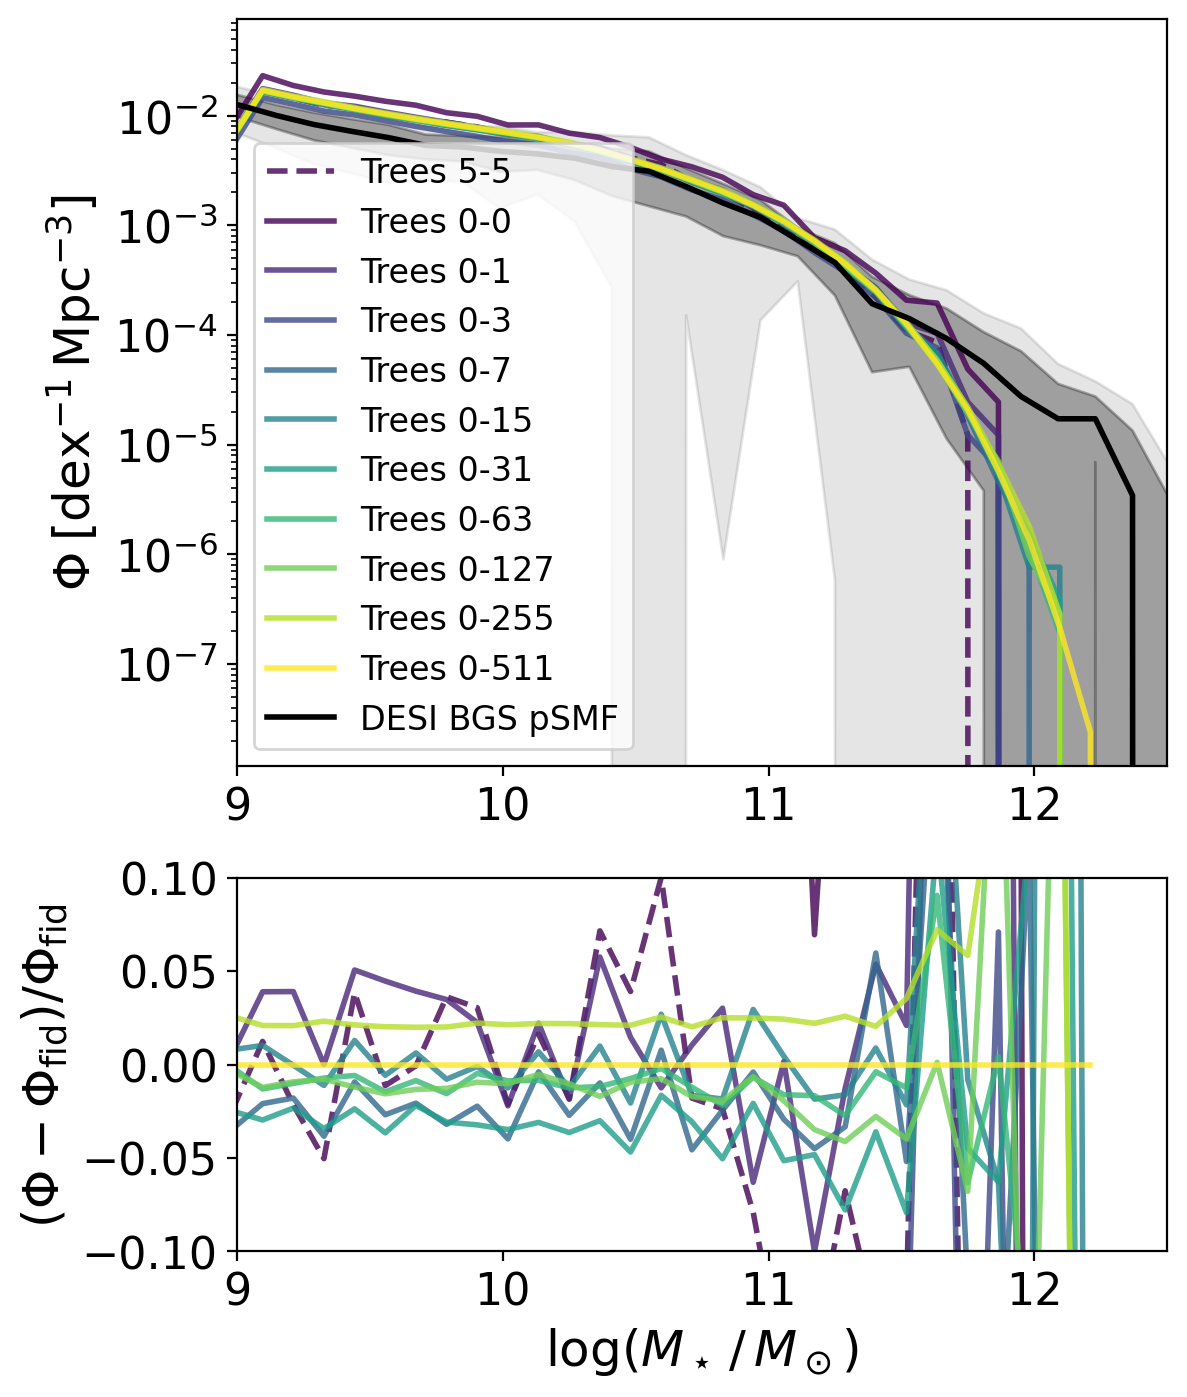

In [11]:
rng = np.random.default_rng()
#colors = ['black']*len(smf_arr)
#color_mode = 'continuous'
n_trees = [len(tree_group) for tree_group in tree_groups]
colors, cmap, locs_norm = utils.get_colors(n_trees, log=True)
#colors = ['green', 'blue', 'purple']
#lss = ['-', '--', '-.', ':', '-', '--', '-.', ':']
lss = ['--']+['-']*(len(smf_arr)-1)
color_mode = None

 
fig, axarr = plt.subplots(2, 1, figsize=(6, 8), #sharex=True, 
                          height_ratios=[2, 1])
ax, ax1 = axarr
 
i_fid = -1
smf_fid = smf_arr[i_fid]

for i in range(len(smf_arr)):
    # if i==0:
    #     label='L-Galaxies SMF'
    # else:
    #     label=None
    #label = tags_lgal[i][1:]
    label = f'Trees {tree_groups[i][0]}-{tree_groups[i][-1]}'
    ax.plot(bins_log_mstar, smf_arr[i], lw=2, color=colors[i], 
             ls=lss[i],
             alpha=0.8, label=label)
    
    print(label)
    #print((smf_arr[i]-smf_fid)/smf_fid)
    ax1.plot(bins_log_mstar, (smf_arr[i]-smf_fid)/smf_fid, lw=2, color=colors[i], 
            ls=lss[i],
            alpha=0.8, label=label)
    
if color_mode=='continuous':
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
    cb = plt.colorbar(sm, ax=ax, extend='max')
    cbar_label = r'$k_\text{AGN}$, efficiency of AGN feedback'
    cb.set_label(label=cbar_label, size=14)
        

ax.plot(ms, psmf_bgs_mean, color='black', label=r'DESI BGS pSMF')
ax.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 )
ax.fill_between(ms, 
                 psmf_bgs_mean-2*psmf_bgs_std, 
                 psmf_bgs_mean+2*psmf_bgs_std,
                 color='black', alpha=0.1,
                 )

# plt.errorbar(m13ksf_log_m_msun, m13ksf_phi_Mpcn3, yerr=m13ksf_err, color='blue', marker='o', 
#              alpha=0.5, markersize=4, ls='None', #facecolor='None', s=8,
#              label='SDSS/PRIMUS \n(Moustakas+2013)')
    
ax.set_xlim(9, 12.5)
ax1.set_xlim(9, 12.5)
#ax1.set_ylim(-0.25, 0.25)
ax1.set_ylim(-0.1, 0.1)

ax.set_yscale('log')
ax1.set_xlabel(r'$\log(M_\star\,/\,M_\odot)$')
ax.set_ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
ax1.set_ylabel(r'$(\Phi-\Phi_\text{fid})/\Phi_\text{fid}$')

handles, labels = ax.get_legend_handles_labels()
if color_mode=='discrete':
    handles.extend(handles_discrete)
ax.legend(handles=handles, fontsize=12)



### Fit bias parameters

In [12]:
sim = fpb.setup_sim(sim_name='millennium', n_threads_bacco=8)

2024-08-20 13:19:39,333 bacco.util : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-20 13:19:39,335 bacco.sims : Setting ngenic_phases=False overruns provided value of phase_type. This will generate a Gadget-3 compatible phase field without Ngenic
2024-08-20 13:19:39,336 bacco.sims : Initialising simulation Default
2024-08-20 13:19:39,337 bacco.sims : ...done in 0.00175 s


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =100672 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =100672 ngrid=512 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: millennium_ics is true, using millennium seed table


2024-08-20 13:19:52,340 bacco.scaler : Adding displacement field with a vel-factor=52.706159


bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.706159 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
LPT sim generated in 0.23955150047938029 min


In [13]:
pbm = fpb.setup_pbm(sim, damping_scale=0.2)

512
damping scale = 0.2
bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =100672 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =100672 ngrid=512 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: millennium_ics is true, using millennium seed table
PB setup in 2.6406803488731385 min


In [14]:
ndens_target = 0.003

TreeFilesTot = 512

pb_arr = []
pb_cov_arr = []
for tree_group in tree_groups:
    print(f"TreeGroup: {tree_group[0]}-{tree_group[-1]}")
    i_group = np.isin(gals['TreeFile'], tree_group)
    gals_group = gals[i_group]
    
    n_trees = len(tree_group)
    pos_arr_hMpc, vel_arr = fpb.load_tracer_data_lgalaxies(ndens_target, box_size, cosmo.pars['hubble'],
                                                           gals=gals_group, n_trees=n_trees)
    print(len(pos_arr_hMpc))
    
    id_arr = np.ones(len(pos_arr_hMpc), dtype=int)
    qdata = fpb.create_qdata_custom(sim, pos_arr_hMpc, vel_arr, id_arr, sim.Nmesh,
                                    number_of_threads=8)
    tracer_q = qdata['pos']
    print("Fitting bias")
    b, bcov = pbm.fit_bias(model=pbm.bias_model, tracer_q=tracer_q,
                            error="jack4")
    #bias_per_object = pbm.bias_model.bias_per_object(pbm.tr_value)
    print(b)
    pb_arr.append(b)
    pb_cov_arr.append(bcov)

TreeGroup: 5-5
Total number of gals initially: 11328
2129
qdata creation set up, finding lagrangian coordinates
nbodies 2129
chunk 0


2024-08-20 13:22:48,166 bacco.sims : Generating displacement field: Di=1.0


0 266
bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, -0.112994, 0.121135); nthreads =48; seed =100672 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =100672 ngrid=128 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss: millennium_ics is true, using millennium seed table
bacco.lss_scaler: Finding lagrangian positions for 266 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
scaler done
chunk 1
266 532
bacco.lss_scaler: Finding lagrangian positions for 266 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
scaler done
chunk 2
532 798
bacco.lss_scaler: Finding lagrangian positions for 266 particles on a 128 grid with 512**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
scaler done
chunk 3
798 1064
bacco.lss_scaler: Finding lagrangian positions for 266 particles o

In [15]:
for tree_group in tree_groups:
    print(f"TreeGroup: {tree_group[0]}-{tree_group[-1]}")
    i_group = np.isin(gals['TreeFile'], tree_group)
    print(f"ngals={np.sum(i_group)}")

TreeGroup: 5-5
ngals=11328
TreeGroup: 0-0
ngals=14661
TreeGroup: 0-1
ngals=23193
TreeGroup: 0-3
ngals=38558
TreeGroup: 0-7
ngals=88476
TreeGroup: 0-15
ngals=181252
TreeGroup: 0-31
ngals=351376
TreeGroup: 0-63
ngals=717697
TreeGroup: 0-127
ngals=1433225
TreeGroup: 0-255
ngals=2961984
TreeGroup: 0-511
ngals=5797330


In [16]:
b_arr = []
b_cov_arr = []
for i in range(len(pb_arr)):
    bias_params, bias_param_names = utils.pbias_params_to_bias_params(dict(zip(pbm.bias_model.terms, pb_arr[i])))
    b_arr.append(bias_params)
    bias_cov, bias_param_names = utils.pbias_params_to_bias_params(dict(zip(pbm.bias_model.terms, pb_cov_arr[i])))
    b_cov_arr.append(bias_cov)
    
b_arr = np.array(b_arr)
b_cov_arr = np.array(b_cov_arr)

In [17]:
bias_param_names_nob1 = bias_param_names.copy()
bias_param_names_nob1.remove('b1')

Text(0.5, 0, '$b_1$')

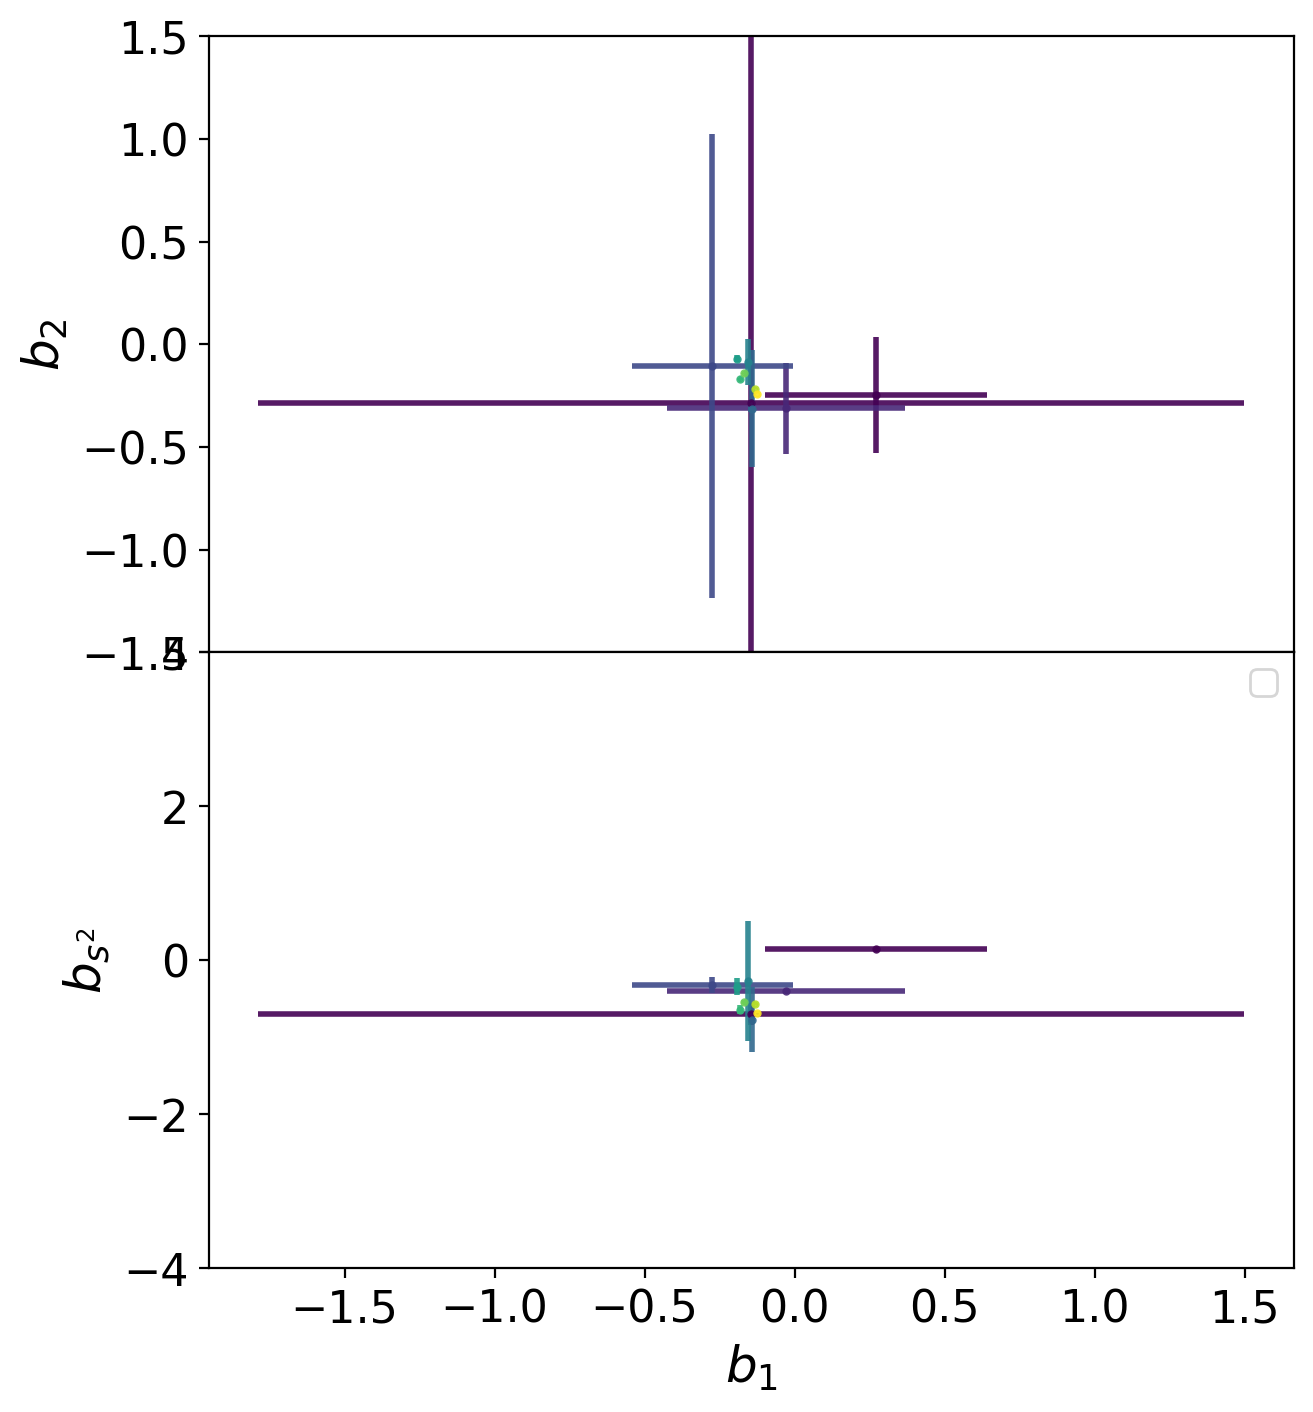

In [18]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(7, 4*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

bp_arr = []
Asn_arr = []


bb_b1 = bias_param_names.index('b1')

for i in range(b_arr.shape[0]):

    for ib, bp_name in enumerate(bias_param_names_nob1):
        
        bb = bias_param_names.index(bp_name)
        
        bval = np.array(b_arr[i,bb])        
        axarr[ib].errorbar(b_arr[i,bb_b1], bval, 
                            yerr=b_cov_arr[i,bb,bb], 
                            xerr=b_cov_arr[i,bb_b1,bb_b1],
                            marker='o', markersize=2, color=colors[i], 
                            ls='None', alpha=0.9)

        axarr[ib].set_ylabel(utils.param_label_dict[bp_name])
    
    
handles, labels = plt.gca().get_legend_handles_labels()
# if color_mode=='discrete':
#     handles.extend(handles_discrete)
plt.legend(handles=handles, fontsize=12)
#plt.xlim(-2, 1)

axarr[0].set_ylim(-1.5, 1.5)
axarr[1].set_ylim(-4, 4)
#axarr[2].set_ylim(-10, 20)

plt.xlabel(utils.param_label_dict['b1'])

# if save_figs:
#     plt.savefig(f'{plot_dir}/bps{plot_tag}{tag_bpfit}.png')

here
here
here


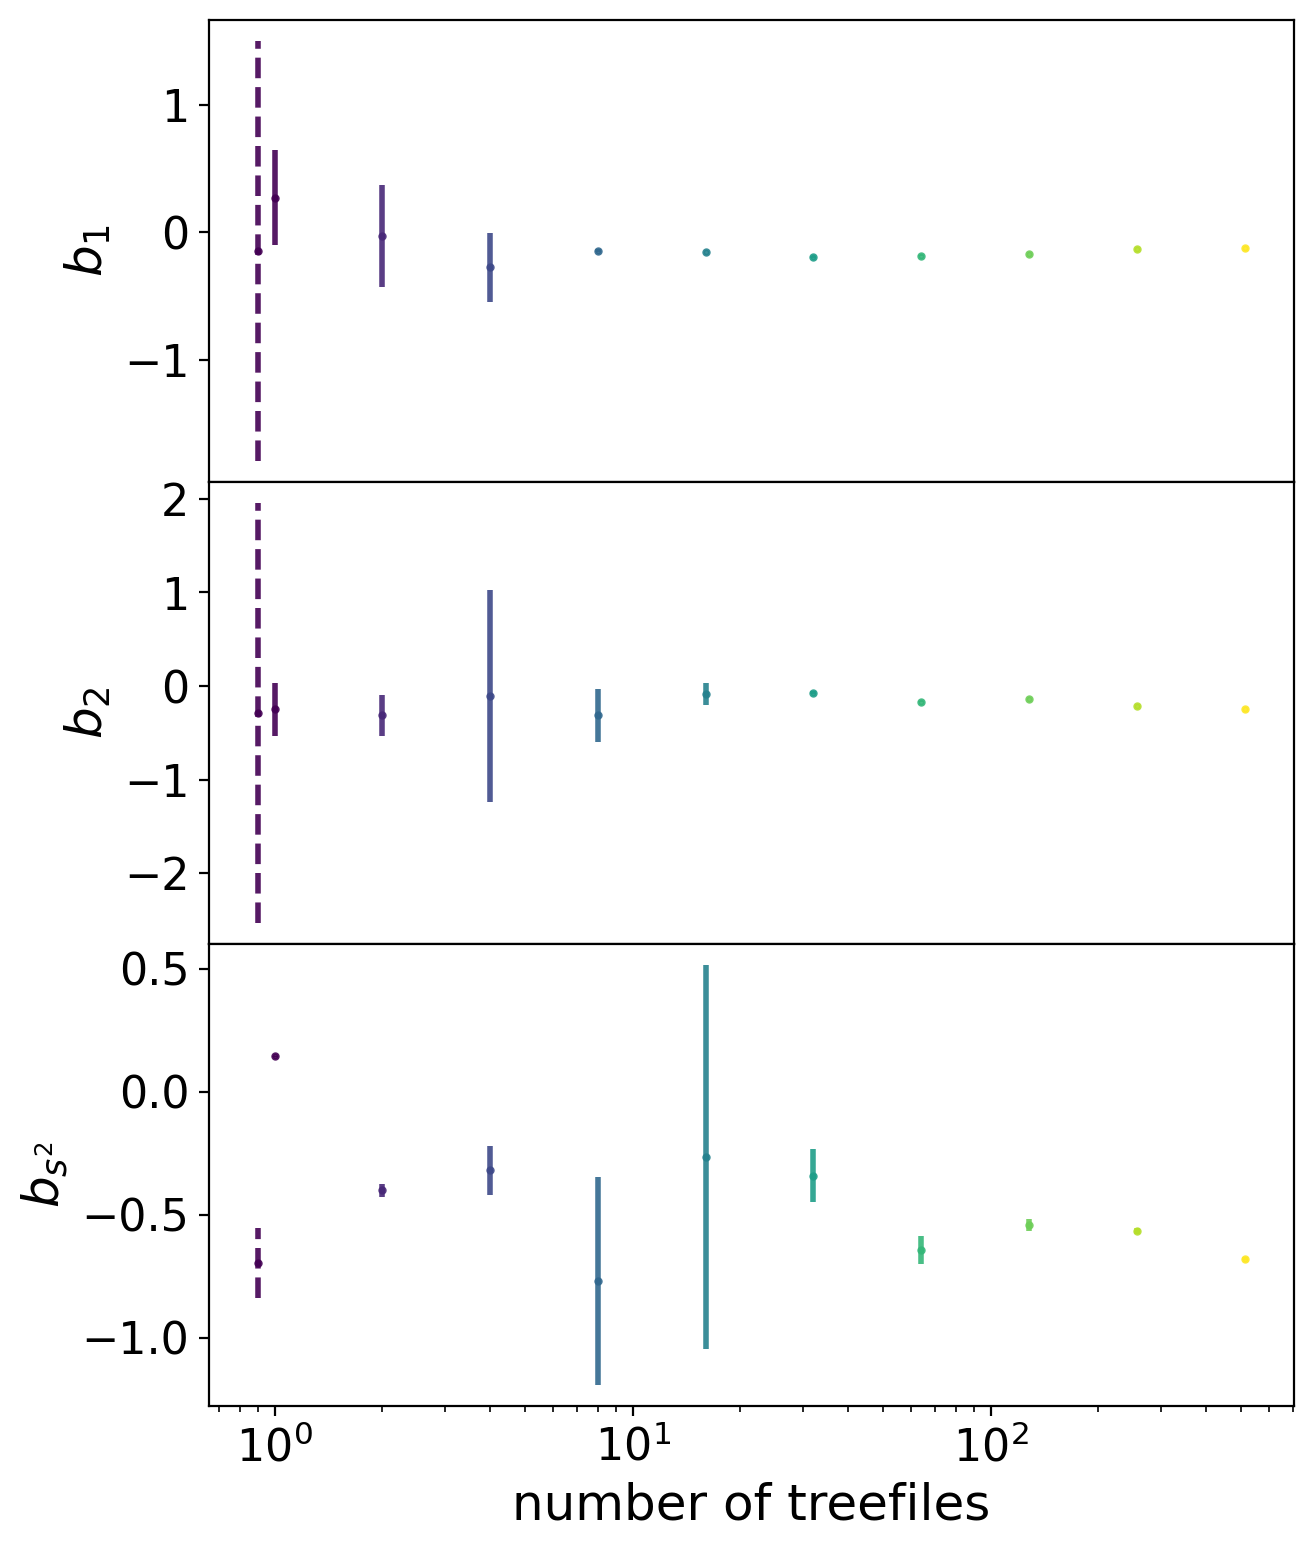

: 

In [19]:
nrows, ncols = len(bias_param_names), 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(7, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

bp_arr = []
Asn_arr = []

bb_b1 = bias_param_names.index('b1')

for i in range(b_arr.shape[0]):

    for ib, bp_name in enumerate(bias_param_names):
        
        bb = bias_param_names.index(bp_name)
        
        bval = np.array(b_arr[i,bb])        
        n_trees = len(tree_groups[i])
        ls = '-'
        if tree_groups[i][0]==5 and tree_groups[i][-1]==5:
            print("here")
            n_trees = 0.9 # for clarity
        
        eb = axarr[ib].errorbar(n_trees, bval, 
                            yerr=b_cov_arr[i,bb,bb], 
                            marker='o', markersize=2, color=colors[i], 
                            ls='None', alpha=0.9)
        if tree_groups[i][0]==5 and tree_groups[i][-1]==5:
            eb[-1][0].set_linestyle('--')

        axarr[ib].set_ylabel(utils.param_label_dict[bp_name])
    
    
handles, labels = plt.gca().get_legend_handles_labels()
# if color_mode=='discrete':
#     handles.extend(handles_discrete)
#plt.legend(handles=handles, fontsize=12)
#plt.xlim(-2, 1)

# axarr[0].set_ylim(-0.5, 0.5)
# axarr[1].set_ylim(-0.5, 0.5)
# axarr[2].set_ylim(-0.75, -0.25)

plt.xlabel('number of treefiles')
plt.xscale('log')

# if save_figs:
#     plt.savefig(f'{plot_dir}/bps{plot_tag}{tag_bpfit}.png')